# Quantizing VS clipping

In [67]:
sequence = "bus"

In [2]:
!../sequences/$sequence/runme.sh

bus_cif.y4m exists.
ffmpeg version n4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10.2.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxcb --enable-libxml2 --enable-libxvid --enable-nvdec --

## Clipping -> Normalizing

In [60]:
!sed -z -i 's!    out = clip(YUV.to_RGB(E_k) + 128)!    #out = clip(YUV.to_RGB(E_k) + 128)!g' image_IPP_adaptive.py
!sed -z -i 's!    dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)\*1!    #dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)\*1!g' image_IPP_adaptive.py
!sed -z -i 's!    #out, max, min = values.norm(YUV.to_RGB(E_k)); out \*= 255!    out, max, min = values.norm(YUV.to_RGB(E_k)); out \*= 255!g' image_IPP_adaptive.py
!sed -z -i 's!    #dq_E_k = YUV.from_RGB(values.denorm(frame.read(prefix, k)/255, max, min))!    dq_E_k = YUV.from_RGB(values.denorm(frame.read(prefix, k)/255, max, min))!g' image_IPP_adaptive.py

In [61]:
!cat -n image_IPP_adaptive.py | grep "out, " 
!cat -n image_IPP_adaptive.py | grep "dq_E_k = YUV" 

   138	    out, max, min = values.norm(YUV.to_RGB(E_k)); out *= 255
   140	    frame.write(out, prefix + "before_", k)
   107	    dq_E_k = YUV.from_RGB(L.read(prefix + "_from_mp4", k))
   144	    #dq_E_k = YUV.from_RGB(frame.read(prefix, k))
   146	    #dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)*1
   148	    #dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)*2
   150	    dq_E_k = YUV.from_RGB(values.denorm(frame.read(prefix, k)/255, max, min))
   151	    #dq_E_k = YUV.from_RGB(frame.read(prefix, k))
   159	    dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)


In [62]:
!python RD_curve.py 1> >(tee /tmp/output >&1) | grep BPP | grep Average | cat -n

     1	Q_step: 21 BPP: 0.3832710788439955 KBPS: 3496.904 Average AMSE: 53.38409397797419
     2	Q_step: 24 BPP: 0.28697127525252525 KBPS: 2618.2799999999997 Average AMSE: 83.10518279584036
     3	Q_step: 27 BPP: 0.20845170454545456 KBPS: 1901.8799999999999 Average AMSE: 128.82897245019643
     4	Q_step: 30 BPP: 0.1483349116161616 KBPS: 1353.384 Average AMSE: 198.67490179573508
     5	Q_step: 33 BPP: 0.10557221520763188 KBPS: 963.224 Average AMSE: 296.37087465365454
     6	Q_step: 36 BPP: 0.0755515221661055 KBPS: 689.3199999999999 Average AMSE: 431.8520725922419
     7	Q_step: 39 BPP: 0.05670507154882155 KBPS: 517.3679999999999 Average AMSE: 602.9597010688483


In [63]:
!grep BPP /tmp/output | grep Average | cut -d ' ' -f 4,9 | tr ' ' '\t'  > /tmp/normalizing.txt

In [64]:
!cat /tmp/normalizing.txt

0.3832710788439955	53.38409397797419
0.28697127525252525	83.10518279584036
0.20845170454545456	128.82897245019643
0.1483349116161616	198.67490179573508
0.10557221520763188	296.37087465365454
0.0755515221661055	431.8520725922419
0.05670507154882155	602.9597010688483


In [65]:
RD_normalizing = []
with open("/tmp/normalizing.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RD_normalizing.append((float(rate), float(_distortion)))

## Normalizing -> Clipping

In [53]:
!sed -z -i 's!    #out = clip(YUV.to_RGB(E_k) + 128)!    out = clip(YUV.to_RGB(E_k) + 128)!g' image_IPP_adaptive.py
!sed -z -i 's!    #dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)\*1!    dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)\*1!g' image_IPP_adaptive.py
!sed -z -i 's!    out, max, min = values.norm(YUV.to_RGB(E_k)); out \*= 255!    #out, max, min = values.norm(YUV.to_RGB(E_k)); out \*= 255!g' image_IPP_adaptive.py
!sed -z -i 's!    dq_E_k = YUV.from_RGB(values.denorm(frame.read(prefix, k)/255, max, min))!    #dq_E_k = YUV.from_RGB(values.denorm(frame.read(prefix, k)/255, max, min))!g' image_IPP_adaptive.py

In [55]:
!cat -n image_IPP_adaptive.py | grep "out = " 
!cat -n image_IPP_adaptive.py | grep "dq_E_k = YUV" 

   134	    out = clip(YUV.to_RGB(E_k) + 128)
   136	    #out = YUV.to_RGB(E_k)//2 + 128
   107	    dq_E_k = YUV.from_RGB(L.read(prefix + "_from_mp4", k))
   144	    #dq_E_k = YUV.from_RGB(frame.read(prefix, k))
   146	    dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)*1
   148	    #dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)*2
   150	    #dq_E_k = YUV.from_RGB(values.denorm(frame.read(prefix, k)/255, max, min))
   151	    #dq_E_k = YUV.from_RGB(frame.read(prefix, k))
   159	    dq_E_k = YUV.from_RGB(frame.read(prefix, k) - 128)


In [56]:
!python RD_curve.py 1> >(tee /tmp/output >&1) | grep BPP | grep Average | cat -n

     1	Q_step: 21 BPP: 0.438279496352413 KBPS: 3998.7920000000004 Average AMSE: 40.97219153338946
     2	Q_step: 24 BPP: 0.3275550645342312 KBPS: 2988.56 Average AMSE: 63.58114324670316
     3	Q_step: 27 BPP: 0.23963155864197533 KBPS: 2186.3599999999997 Average AMSE: 99.81794540456649
     4	Q_step: 30 BPP: 0.17150059624017958 KBPS: 1564.7440000000001 Average AMSE: 156.88415425960997
     5	Q_step: 33 BPP: 0.12153303872053872 KBPS: 1108.8480000000002 Average AMSE: 239.72344352816359
     6	Q_step: 36 BPP: 0.08728079405162739 KBPS: 796.3359999999999 Average AMSE: 350.3104936079545
     7	Q_step: 39 BPP: 0.06542683782267115 KBPS: 596.9440000000001 Average AMSE: 496.22877867213805


In [57]:
!grep BPP /tmp/output | grep Average | cut -d ' ' -f 4,9 | tr ' ' '\t'  > /tmp/clipping.txt

In [58]:
!cat /tmp/clipping.txt

0.438279496352413	40.97219153338946
0.3275550645342312	63.58114324670316
0.23963155864197533	99.81794540456649
0.17150059624017958	156.88415425960997
0.12153303872053872	239.72344352816359
0.08728079405162739	350.3104936079545
0.06542683782267115	496.22877867213805


In [59]:
RD_clipping = []
with open("/tmp/clipping.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RD_clipping.append((float(rate), float(_distortion)))

## Comparison

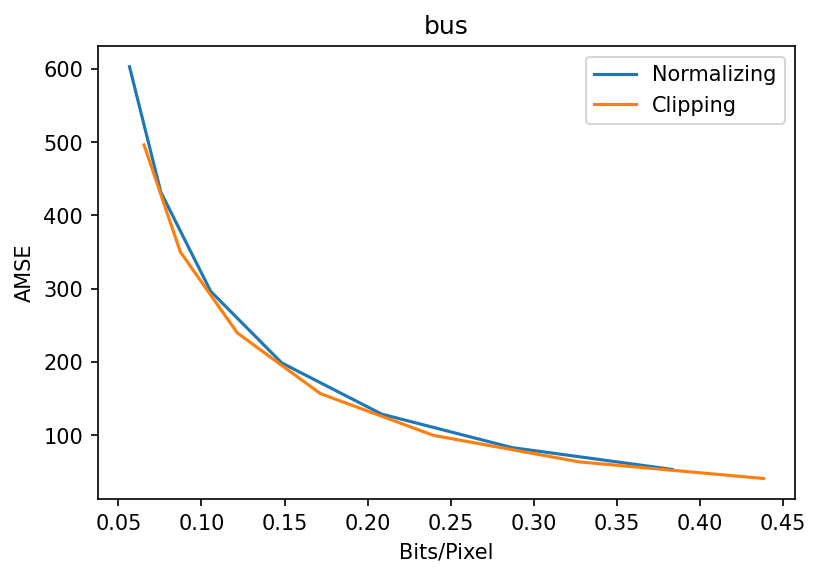

In [68]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import pylab

pylab.figure(dpi=150)
pylab.plot(*zip(*RD_normalizing), label="Normalizing")
pylab.plot(*zip(*RD_clipping), label="Clipping")
pylab.title(f"{sequence}")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("AMSE")
plt.legend(loc='upper right')
pylab.show()